<img src="images/charizard.png" alt="Expert" width="200">

# Expert level

<img src="http://www.animatedgif.net/underconstruction/5consbar2_e0.gif">
<div style="border: 5px solid red; padding: 20px;"><p>I'm currently writing the exercise for this level. It is not done yet, but it will be before the workshop begins!</p></div>
<img src="http://www.animatedgif.net/underconstruction/5consbar2_e0.gif">

Welcome to the expert level!
For this level, I'm assuming you are somewhat familiar with the Python programming language, for example by completing the ['adept'](adapt.ipynb) level, or having done some other projects in Python.
Alternatively, if you have enough experience in other programming languages, you can follow along.
If some aspect of the Python programming language is unclear, I found Jake VanderPlas' ["A whirlwind tour of Python"](http://www.oreilly.com/programming/free/files/a-whirlwind-tour-of-python.pdf) a great reference to quickly look things up.

During the next half hour, we are going to construct a basic pipeline that begins with some raw MEG data and performs a minimum-norm estimate (MNE) of the cortical sources.

## The experiment

I have prepared a bit of MEG data for you. It was recorded while a brave volunteer was in the scanner, listening to auditory beeps and looking at visual checkerboards. The volunteer was staring at a "fixation cross" in the center of a screen in front of him/her. From time to time, beeps sounded from either the left or the right side of his/her head. At other times, a checkerboard would be displayed either to the left or right side of to the cross. The volunteer was instructed to keep his/her eyes fixed on the cross and not directly look at the checkerboards. This way, the checkerboard was presented either to the left or right visual field of the volunteer.

<center>
    <img src="images/sound.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/checkerboard.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/cross.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/checkerboard.png" width="100" style="display: inline; margin-right: 50px">
    <img src="images/sound.png" width="100" style="display: inline; transform: scaleX(-1);">
</center>

By analyzing the MEG signal, we should be able to see the activity in the auditory and visual cortices.

## Some housekeeping

First order of business is to import the MNE-Python module `mne` and configure the graphics engine to send all figures to the browser.
Executing the cell below will accomplish this.

In [1]:
# Import the MNE-Python module, which contains all the data analysis routines we need
import mne
print('MNE-Python imported.')

# Configure the graphics engine
from matplotlib import pyplot as plt
plt.rc('figure', max_open_warning=100)
%matplotlib inline
from mayavi import mlab  # Mayavi is used for 3D graphics
mlab.init_notebook('png')  # This instructs Mayavi to render in the background and send png graphics to the browser
print('From now on, all graphics will send to your browser.')

MNE-Python imported.
Notebook initialized with png backend.
From now on, all graphics will send to your browser.


## Overview of MNE-Python and how to view the documentation

The MNE-Python software module is subdivided in several sub-modules, all housing classes and functions related to different aspects of data analysis. Here are the sub-modules that are relevant for this exercise:

[`mne`](https://www.martinos.org/mne/stable/python_reference.html#module-mne) - Top level module, containing general purpose classes/functions as well as all sub-modules  
[`mne.io`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.io) - Functions related to loading data in different formats  
[`mne.viz`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.viz) - Functions related to data visualization  
[`mne.minimum_norm`](https://www.martinos.org/mne/stable/python_reference.html#module-mne.minimum_norm) - Classes and functions related to performing minimum norm estimates (MNE)

Documentation of all functions and classes can be found at the [Python API reference](https://www.martinos.org/mne/stable/python_reference.html) page.
For quick access, all class/function names used in this notebook are also links to their respective documentation pages.
To use MNE-Python effectively for your own projects, you need to be able to use the documentation.
Therefore, I'm not going to spell out how to call each function, but instead want you to use the documentation to look up this information.

## Loading data

Let's dive in by loading some data and looking at the raw signal coming out of the MEG scanner.
The function to load the FIFF files that are produced by the recording software is called [`mne.io.read_raw_fif`](https://www.martinos.org/mne/stable/generated/mne.io.read_raw_fif.html). Take a look at its documentation. From the function signature we can see the function has one required argument, the name of the file to load, and several optional arguments that we can leave alone for now.

The file with the raw data is `'data/sample-raw.fif'`.
In the cell below, write the line of code to load it using the [`mne.io.read_raw_fif`](https://www.martinos.org/mne/stable/generated/mne.io.read_raw_fif.html) function and store the result in a variable called `raw`.

In [2]:
# Write your line of code here
raw = mne.io.read_raw_fif('data/sample-raw.fif')

Opening raw data file data/sample-raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 59)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0


If the code was correct, the cell below will visualize the raw data, using an interactive figure.
Click in the scrollbars or use the arrow keys to scroll through the data.

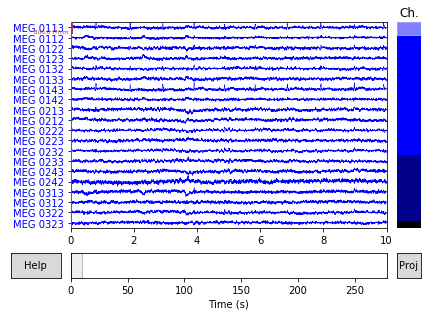

In [3]:
# Lots of MNE-Python objects have a .plot() method, and mne.Raw is no exception
raw.plot();  # Note the semicolon ; at the end, see the text below to find out why

<div style="border: 3px solid #aaccff; margin: 10px 100px; padding: 10px">
    <b>What's with the semicolon ; ?</b>
    
The Jupyter notebook you are working in right now displays the result of the last statement in a code cell. The plotting functions return a figure object. Therefore, if the last statement of a cell is a call to a plotting function, the figure is displayed twice: one when the function is called, and once more when the figure object is displayed by the Jupyter notebook. By ending a line with a semicolon `;`, we suppress the result by starting a new empty statement.
</div>

Browsing through the channels, you will notice there are several channel types:

 * <span style="color: #0000ff">204 MEG gradiometers (102 pairs of two)</span>
 * <span style="color: #00008b">102 MEG magnetometers</span>
 * 9 STIM channels
 * 1 EOG sensor
 
All these channels record different information about the volunteer and the environment.

Staring at the raw data is not very helpful.
The brain is constantly doing all kinds of things, so there are a lot overlapping signals in the data.

For this exercise, we are interested only in the signals that are related to processing the visual and auditory stimuli that were presented to the volunteer.
Let's start by cutting out only the pieces of signal surrounding the times at which a stimulus was presented.
Of course, that means we first have to figure out *when* stimuli were presented.
For this, we can use the STIM channels.

## The STIM channels and events

In the figure you just made, scroll down and take a look at channel `STI 014`.
On this channel, the computer that is presenting the stimuli was sending timing information to the MEG equipment.
Whenever a stimulus (checkerboard or beep) was presented, the signal at this channel jumps briefly from 0 to either 1, 2, 3 or 4, indicating the type of stimulus.

We can use this channel to create an "events" matrix: a table listing all the times a stimulus was presented, along with the time of the event and the type of stimulus.
The function to do this is called [`mne.find_events`](https://www.martinos.org/mne/stable/generated/mne.find_events.html), and creates a 2D [NumPy array](https://docs.scipy.org/doc/numpy/user/quickstart.html) containing all the events along with when they occurred and a numerical code indicating the type of event.

The event array can be visualized using the [`mne.viz.plot_events`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_events.html) function.

In the cell below, use the [`mne.find_events`]() function to create an array called `events`, then visualize it using the [`mne.viz.plot_events`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_events.html) function:

320 events found
Event IDs: [ 1  2  3  4  5 32]


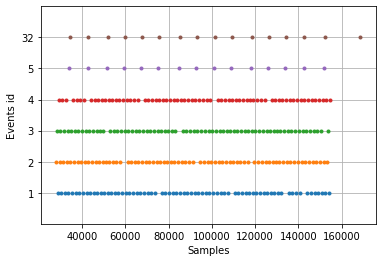

In [4]:
events = mne.find_events(raw)
mne.viz.plot_events(events);

The system generated 6 types of events. We are interested in events with ids 1 to 4, which correspond to the presentation of one of the four different type of stimuli. Lets give them names. Here is a dictionary mapping string names to event ids:

In [5]:
event_id = {
    'audio/left': 1,
    'audio/right': 2,
    'visual/left': 3,
    'visual/right': 4
}

## Creating epochs

Now that we have the information on what stimulus was presented at one time, we can extract "epochs".
Epochs are little snippets of signal surrounding an event.
These epochs can then be averaged to produce the "evoked" signal.

To cut up the continuous data into epochs, create an [`mne.Epochs`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html) object. Pass the `raw` data, the `events` array and the `event_id` dictionary as parameters.
By default, epochs will be cut starting from 0.2 seconds *before* the onset of the event until 0.5 seconds *after* the onset.
These defaults are fine for the data we're currently analyzing.

<div style="border: 3px solid #aaccff; margin: 10px 100px; padding: 10px">
    <b>A note on creating objects in Python</b>
    
In the Python programming language, creating objects is very similar to calling functions.
To create an object of a certain class, you call the class name as a function.
For example, to create an object of type `str`, you call `str()`.
You can pass parameters like usual: `str('my string')`.
</div>

The created [`mne.Epochs`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html) object has a `.plot()` method (like so many of MNE-Python's objects).
Try calling it to visualize the epochs. Don't forget to put a semicolon `;` at the end of your plotting call or the figure will show twice.

Write some code in the cell below to create the epochs and visualize them:

289 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
4 projection items activated
Loading data for 289 events and 421 original time points ...
0 bad epochs dropped
Loading data for 94 events and 421 original time points ...
Loading data for 20 events and 421 original time points ...


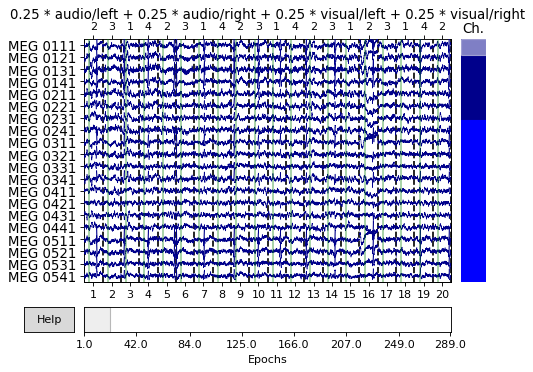

In [6]:
epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5)
epochs.plot();

The figure you just created is interactive. Try clicking in the scrollbars and using the arrow keys to explore the data. Also try pressing the `b` key to switch to "butterly" mode. In this mode, all the channels are plotted on top of each other. This is a great mode for quickly checking data quality: can you spot any epochs containing anomalous spikes caused by eye-blinks and movements of the volunteer? Clicking on epochs will turn them red, causing them to be dropped from further analysis after clicking the "end interaction" button that looks like this: <img src="images/end_interaction.png" width="30" style="display: inline-block; vertical-align: middle; margin: 0px;">.

## Visualizing the evoked field

So now we have snippets of signal that are likely contain data that is related to the processing of the stimuli.
However, there are still so many overlapping signals it's difficult to see anything.

During the talks earlier today, you have heard about "evoked" data.
By averaging all the epochs corresponding to a stimulus, signals that are consistently present every time a stimulus was presented will remain, while all other signals will more or less cancel out.
The result is referred to as the "evoked" field (i.e. signals that are "evoked" by the stimulus).

Averaging epochs is simple, the [`mne.Epochs`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html) object has a method called [`average`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html#mne.Epochs.average) for exactly that purpose.
The method doesn't need any parameters (there are some optional ones, but we can leave them alone for now) and produces a new object of type [`mne.Evoked`](https://www.martinos.org/mne/stable/generated/mne.Evoked.html).
Of course, this evoked object also has a [`plot`](https://www.martinos.org/mne/stable/generated/mne.Evoked.html#mne.Evoked.plot) method you can use to have a basic visualize it, but also a [`plot_joint`](https://www.martinos.org/mne/stable/generated/mne.Evoked.html#mne.Evoked.plot_joint) method that provides a much better visualization.

Another useful feature of the [`mne.Epochs`](https://www.martinos.org/mne/stable/generated/mne.Epochs.html) object is that it behaves as a Python dictionary.
To select all the epochs that correspond to a specific event type, you can index the object like so:

```python
epochs['visual/left']
```

(it uses the string descriptions that we defined in the `event_id` dictionary earlier on.)
Hence, to visualize the evoked field in response to a checkerboard presented in the left visual field of the volunteer, we write:

```python
epochs['visual/left'].average().plot_joint()
```

In the cell belows, visualize the evoked fields for all four stimuli:

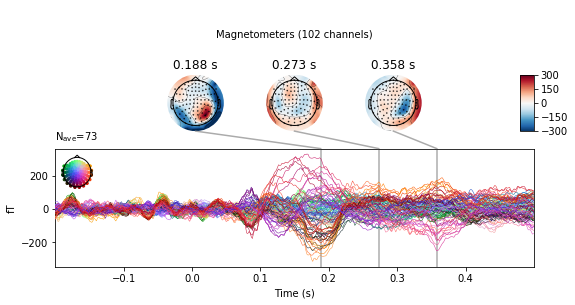

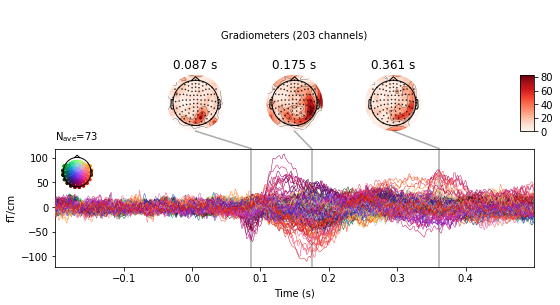

In [7]:
epochs['visual/left'].average().plot_joint();

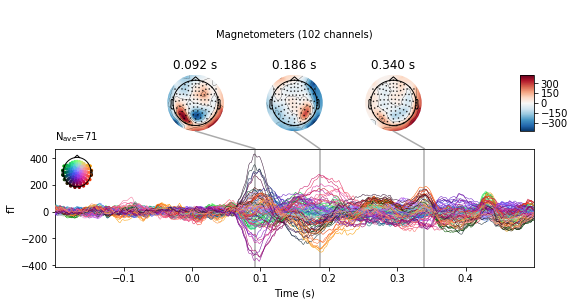

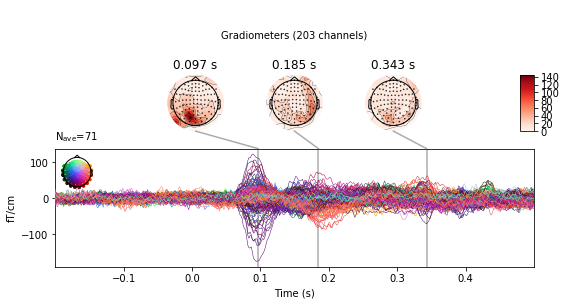

In [8]:
epochs['visual/right'].average().plot_joint();

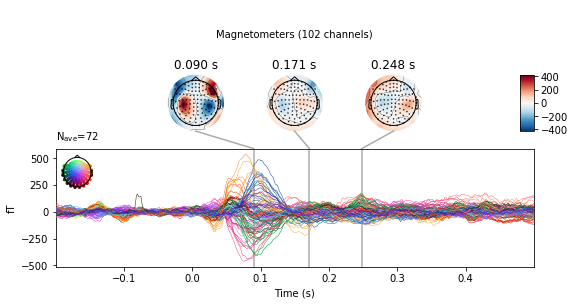

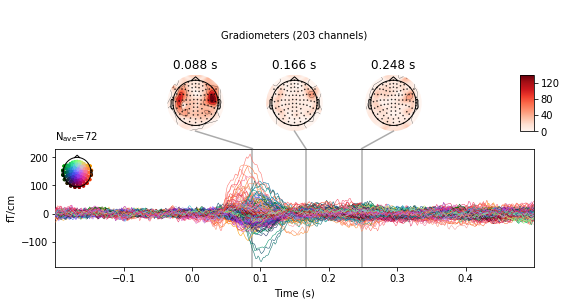

In [9]:
epochs['audio/left'].average().plot_joint();

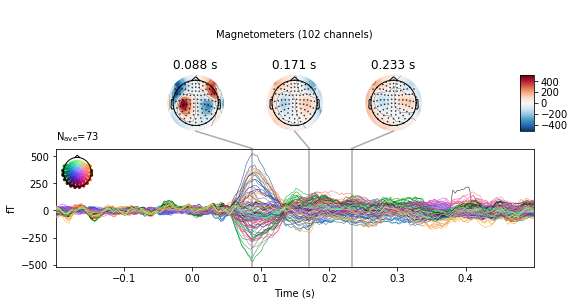

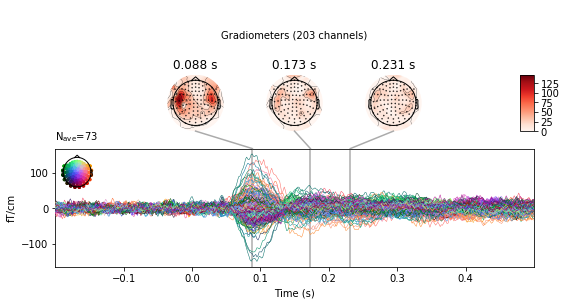

In [10]:
epochs['audio/right'].average().plot_joint();

From the evoked data, we can see several bursts of activity following the presentation of a stimulus.
You can also see how the different sensors (magnetometers and gradiometers) pick up the same signal.
Looking at the topographic maps (the "heads"), you can already see how the visual stimuli generated activity at the back of the head, where the visual cortex is located, and how auditory stimuli generated activity on the side of the head, where the auditory cortices are located.

But let's turn it up a notch and try to estimate and visualize the cortical origins of the evoked fields.

## Loading the MRI data and the concept of "subjects_dir"

As you may remember from the talks earlier today, we can use MRI data to create a detailed model of the head, which allows us to simulate the signals propagating from the cortex to the MEG sensors, which in turn allows us to estimate the cortical origins of the signal.

Processing the raw MRI data into a 3D head model takes about 24 hours and is performed by a program called [FreeSurfer](https://surfer.nmr.mgh.harvard.edu).
We don't have that kind of time right now, so I ran the program in advance for you.
FreeSurfer stores its output in a folder, which is available on this system as `data/mri`.
Inside this folder is a subfolder for each subject.
We only have one subject, called `sample`.

We are not going to load all of the FreeSurfer data into memory.
Instead, we're going to inform MNE-Pythnon where the MRI folder (`'data/mri'`) is located on the system, so the required data can be loaded as needed.
The cell below accomplishes this:

In [11]:
# This code sets an environment variable called SUBJECTS_DIR
import os
os.environ['SUBJECTS_DIR'] = 'data/mri'

The `data/mri` folders contains the MRI data for all volunteers that participated in the experiment.
In our case, there is only one volunteer, named `sample`.
All the MNE-Pythons that need access to the head model take a parameter `subject`, that needs to be set to `'sample'` in our case.
With access to both the FreeSurfer folder and the subject name, the function knows where to find the head model data it needs.

Another tedious task is to align the coordinate frames of the MRI and the MEG scanners, which requires some interactive tools that unfortunately don't work in the browser.
The result of this alignment process is a coordinate transformation object, which I have also prepared for you in advance.
This transformation will be loaded into memory, which the line of code below will do for you:

In [12]:
trans = mne.read_trans('data/sample-trans.fif')

To visualize the head model and check if the coordinate systems have been properly aligned, you can use the [`mne.viz.plot_alignment`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_alignment.html) function.
Take a look at its documentation and you will see you can pass a whole list of different objects to this function.
The purpose of the function is to visualize everything you give it in the same coordinate space.
If everything lines up properly, we're good to go!

The line of code below will call the function.
Take note of the `subject` parameter.
You will need to use this parameter for any function calls that need access to the head model.

Using outer_skin.surf for head surface.
Getting helmet for system 306m



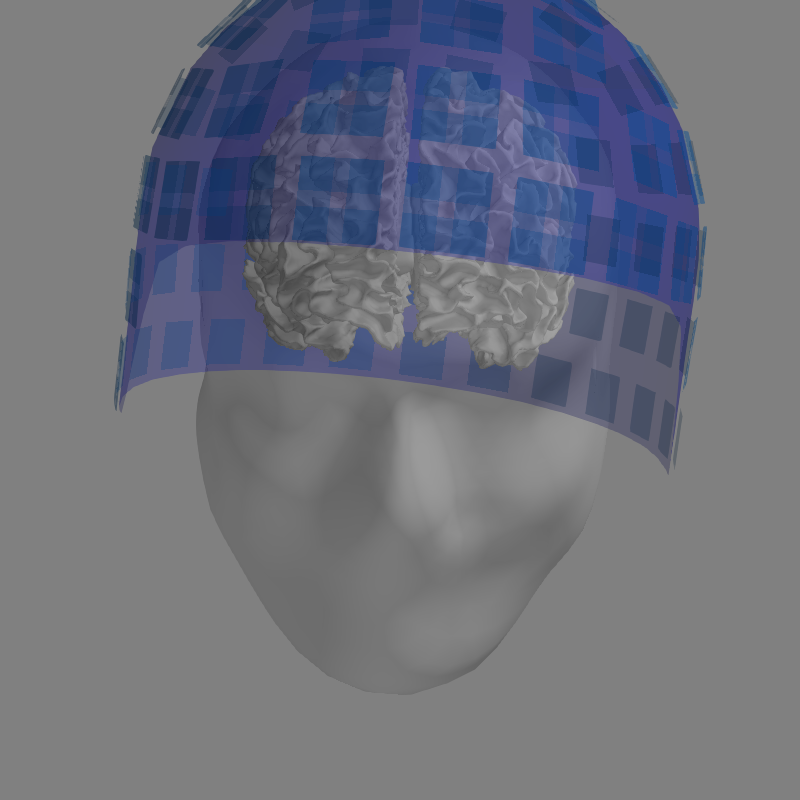

In [13]:
mne.viz.plot_alignment(epochs.info, trans, subject='sample', surfaces=['white', 'outer_skin'])

The above figure is interactive. Drag on the figure to rotate the 3D model and check that the brain and head, which are generated from the MRI images, are aligned nicely with the MEG helmet and the EEG sensors, which locations are taken from the `epochs.info` dictionary.

## Creating a source space

We are going to estimate the cortical orgins of the signals by creating a fine grid of points along the cortex.
More precisely, we're going to put these points on the boundary between the white and gray matter of the brain.
Then, we will compute for each grid point, a spatial filter that attempts to isolate any signals possibly originating from that point.
Taken together, the estimated activity at all the grid points give a complete picture of the estimated signals originating from all over the cortex.

To define the grid points, or the "source space" as MNE-Python calls it, we can use the [`mne.setup_source_space`](https://www.martinos.org/mne/stable/generated/mne.setup_source_space.html) function.
This function needs the `subject` parameter that you saw before used in the [`mne.viz.plot_alignment`](https://www.martinos.org/mne/stable/generated/mne.viz.plot_alignment.html) function.
There are some other, optional, parameter you want to set to increase the computation speed.
You want to set `add_dist=False` to disable the very lengthy point-to-point distance computation that we don't need for this exercise.
You can leave the rest of the parameters at their default values.

The [`mne.setup_source_space`](https://www.martinos.org/mne/stable/generated/mne.setup_source_space.html) function produces an object of the type [`mne.SourceSpaces`](https://www.martinos.org/mne/stable/generated/mne.SourceSpaces.html) (plural, because it creates a separate source space for each hemisphere).
This object has, you guessed it, a [`plot`](https://www.martinos.org/mne/stable/generated/mne.SourceSpaces.html#mne.SourceSpaces.plot) method to visualize it.

Create a source space, store it in a variable named `src` and visualize it:

Setting up the source space with the following parameters:

SUBJECTS_DIR = data/mri
Subject      = sample
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading data/mri\sample\surf\lh.white...
Mapping lh sample -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from data/mri\sample\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/155407 selected to source space (oct = 6)

Loading data/mri\sample\surf\rh.white...
Mapping rh sample -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from data/mri\sample\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/156866 selected to source space (oct = 6)

You are now one step closer to computing the gain matrix



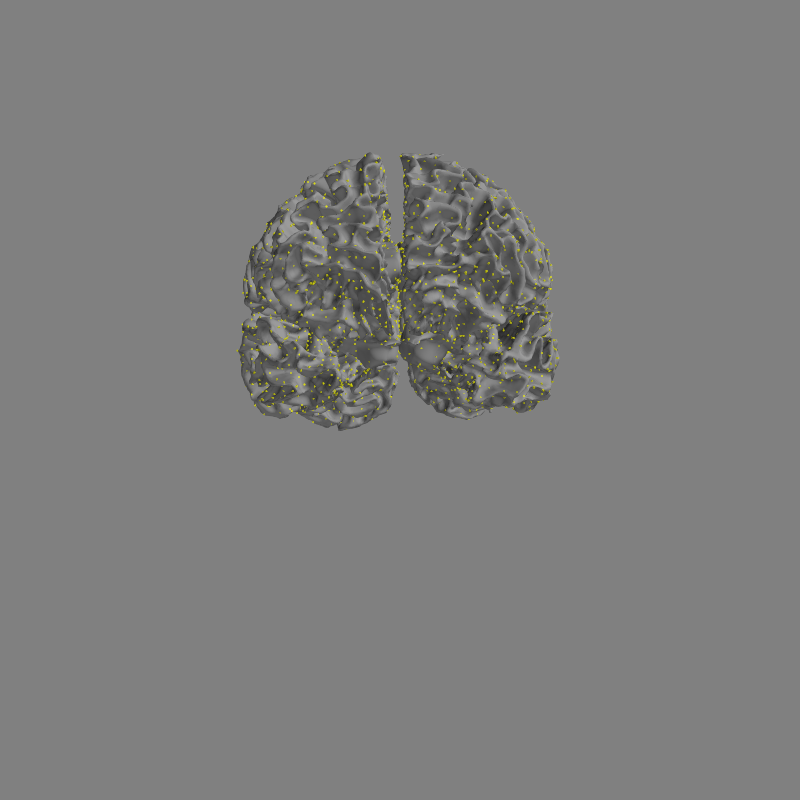

In [14]:
src = mne.setup_source_space(subject='sample', add_dist=False)
src.plot(subjects_dir='data/mri')

## The forward model

With the head model and source space in place, we can compute the forward model (or forward "solution" as MNE-Python calls it).
This is a simulation of the magnetic fields originating from the grid points of the source space, propagating through the various tissues in the head model to reach the MEG sensors.

It is created by the [`mne.make_forward_solution`](https://www.martinos.org/mne/stable/generated/mne.make_forward_solution.html?highlight=make_forward) function.
This function has four required parameters:

 1. the `epochs.info` dictionary containing information about the sensors
 2. the coordinate tranformation `trans` that aligns the coordinates of the MRI with that of the MEG scanner.
 3. the source space `src` we just created
 4. the location of the physical model of the various tissues in the head. This has been computed by the FreeSurfer program and can be found at: `bem='data/mri/sample/bem/bem-sol.fif'`.
 
Go ahead and create the forward model and store it in a variable called `fwd`:

In [15]:
fwd = mne.make_forward_solution(epochs.info, trans, src, bem='data/mri/sample/bem/bem-sol.fif')

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=156866, n_used=4098, coordinate_frame=MRI (surface RAS)>]>
MRI -> head transform : instance of Transform
Measurement data      : instance of Info
Conductor model   : data/mri/sample/bem/bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  0.000000       1.00

Read 305 MEG channels from info
84 coil definitions read
Coordinate transformation: MEG device -> head
     0.991420 -0.039936 -0.124467      -6.13 mm
     0.060661  0.984012  0.167456       0.06 mm
     0.115790 -0.173570  0.977991      64.74 mm
     0.000

If all went well, the following line of code will plot the sensitivity profile: how well the MEG sensors pick up signals from each grid point of the source space.
You will see that the closer a grid point is to a MEG sensor, the better we can see signals originating from it.

    203 out of 305 channels remain after picking
Using control points [0.6099924  0.63770801 0.82959033]



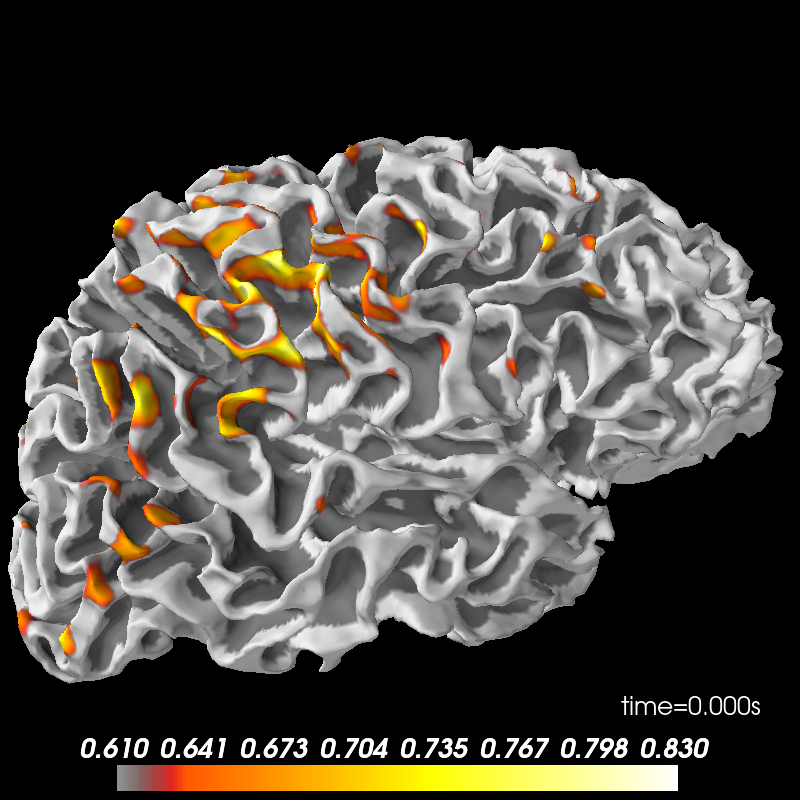

In [16]:
mne.sensitivity_map(fwd).plot(hemi='both', surface='white')

## The inverse model

The forward model we just computed can simulate signals originating from the cortex to the MEG sensors.
We want to go the other way: tracing signals originating from the MEG sensors back to their cortical origin.
To "invert" the forward model, we will use the minimum-norm estimate (MNE) method.
This method combines the [covariance](https://en.wikipedia.org/wiki/Covariance_matrix) between the sensors with the forward model to construct a suitable inverse model.

We can use the [`mne.compute_covariance`](https://www.martinos.org/mne/stable/generated/mne.compute_covariance.html) function to compute the covariance between the sensors.
For the MNE method, we need to compute this using only the data just *before* the stimulus was presented.
If we regard the time at which the stimulus was presented as 0.
It is also a good idea to apply some [shrinkage](https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices#Shrinkage_estimation) to the covariance matrix, which will make the solution better behaved.

Call the [`mne.compute_covariance`](https://www.martinos.org/mne/stable/generated/mne.compute_covariance.html), give it the `epochs`, set `tmax=0` and set `method='shrunk'`.
Store the result in a variable called `cov`:

In [17]:
cov = mne.compute_covariance(epochs, tmax=0, method='shrunk')

Loading data for 72 events and 421 original time points ...
Loading data for 73 events and 421 original time points ...
Loading data for 73 events and 421 original time points ...
Loading data for 71 events and 421 original time points ...
Computing data rank from raw with rank=None
    Using tolerance 1.4e-08 (2.2e-16 eps * 305 dim * 2.1e+05  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 305 -> 302
Estimating covariance using SHRUNK
Done.
Number of samples used : 34969
[done]


If all went well, the following line will plot some information about the covariance matrix you just computed:

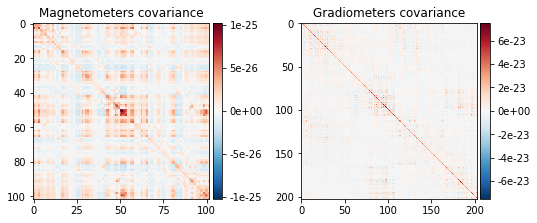

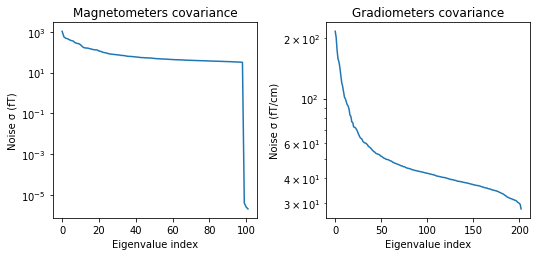

In [18]:
mne.viz.plot_cov(cov, epochs.info);

Now we can compute the actual inverse solution, or inverse "operator" as MNE-Python calls it.
This is done with the [`mne.minimum_norm.make_inverse_operator`]() function.
It has as required parameters the `epochs.info` dictionary, the forward model `fwd` and the covariance `cov` we just computed.
Store the result in a variable called `inv`:

In [19]:
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 305 channels.
    305 out of 305 channels remain after picking
Selected 305 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 2764/8193 = 10.003177
    scale = 7.8773e-07 exp = 0.8
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing data rank from covariance with rank=None
    Using tolerance 3.8e-13 (2.2e-16 eps * 305 dim * 5.6  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 71
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "visual/right"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  66.0% variance
    Combining the current components...
    dSPM...
[done]
Using control points [ 3.10892878  3.58485859 12.79842149]



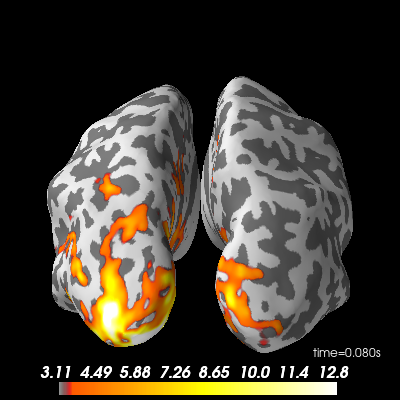

In [21]:
from mne.minimum_norm import apply_inverse

# Apply inverse solution
snr = 3.0
lambda2 = 1.0 / snr ** 2
stc = apply_inverse(epochs['visual/right'].average(), inv, lambda2, 'dSPM')

# Plot the source estimate
stc.plot(initial_time=0.08, hemi='both', size=400,
         subjects_dir='data/mri',
         views=['caudal'])